### Performance comparison of SLS and LQR controllers with bound constraints on the control and on the state 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from copy import deepcopy
from time import time
from isls import SLS
from isls.utils import get_double_integrator_AB
from isls.projections import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

### Problem setup

In [2]:
x_dim = 1
u_dim = 1
T = 1.
horizon = 100
nb_deriv = 2
N = horizon
dt = T/horizon
print("dt:", dt)
d = x_dim*nb_deriv
A, B = get_double_integrator_AB(x_dim, nb_deriv=nb_deriv, dt=dt)

dt: 0.01


In [3]:
%%time
sls = SLS(d, u_dim, horizon)
sls.AB = [A,B]

Wall time: 0 ns


Define the task:

In [4]:
u_std = 1e-4
x_std = 1e3
x_final_target = np.array([1., 1.])
viaQ_final = np.diag([0., 0.])

free_state = np.zeros(d)
viaQ_free = np.diag([0.]*d)

zs = np.stack([free_state,  x_final_target])
Qs = np.stack([viaQ_free,  viaQ_final])

seq = np.zeros(N, dtype=np.int32)
seq[N-1] = 1

In [5]:
sls.set_cost_variables(zs, Qs, seq, u_std)

In [6]:
x0 = np.zeros(d)
x_opt, u_opt = sls.solve_batch(x0)

In [7]:
x_opt[-1]

array([0., 0.])

## ADMM Optimization with state bounds on the given timestep

### Define constraints

### Batch LQT - ADMM

In [8]:
# State constraints
lower_x_final = 0.5
upper_x_final = 0.5
lower_dx = -1.5
upper_dx = 1.5

def project_position(x):
    return project_bound(x, lower_x_final, upper_x_final)

def project_velocity(x):
    return project_bound(x, lower_dx, upper_dx)

def project_x(x):
    x_ = x.reshape(N,-1).copy()
    x_[-1, 0] = project_position(x_[-1, 0])
    x_[-1, 1] = 0.
    return x_.flatten()


# Control constraints
lower_u = -3.
upper_u = 3.
nb_proj = 1
project_u = lambda u: project_bound(u, lower_u, upper_u) 

ADMM converged at iteration  10 !
ADMM residual is  4.26e-04 2.61e-04
0.49996233221754366 2.5271873599684085 0.79950083260166
Constrained cost is 3.16e-02
Unconstrained cost is 0.00e+00
Wall time: 122 ms


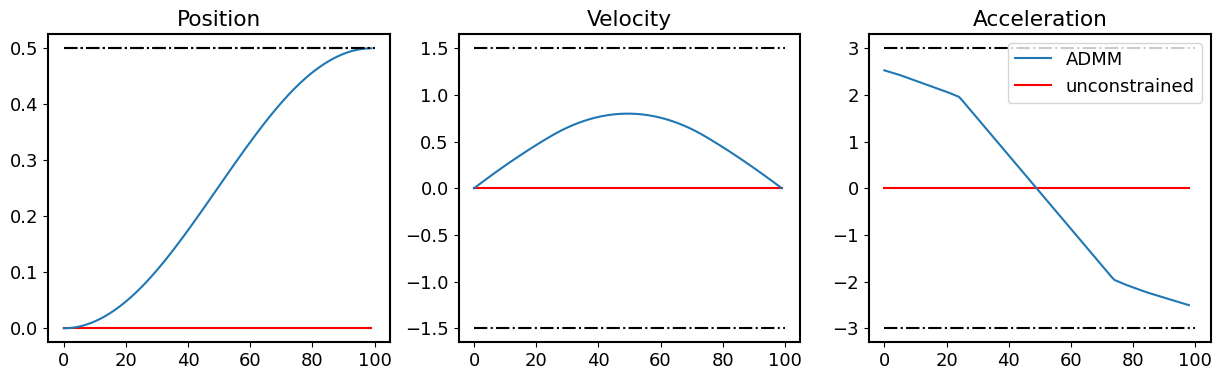

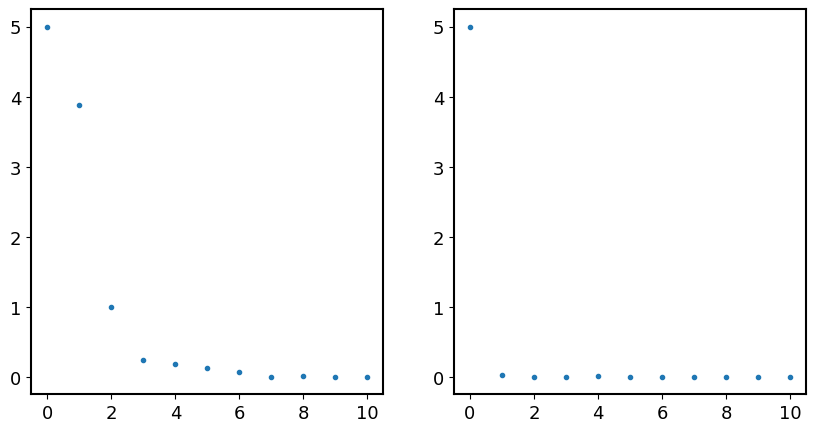

In [9]:
%%time
rho_u = 1e-3
rho_x = np.zeros((N,d,d))
rho_x[-1,1,1] = 1e1
rho_x[-1,0,0] = 1e1
max_iter=500
x_optimal, u_optimal, log = sls.ADMM_LQT_Batch(np.zeros(d),project_u=project_u, project_x=project_x,
                                               max_iter=max_iter, rho_x = rho_x, rho_u=rho_u, threshold=1e-3, verbose=True, log=True)
print(x_optimal[-2], np.max(u_optimal), np.max(x_optimal.reshape(N,-1)[:,1]))
fig,ax = plt.subplots(ncols=3, figsize=(15,4))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal

ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "-.k")
ax[0].plot([0,N],[upper_x_final]*2, "-.k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(x_opt[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "-.k")
ax[1].plot([0,N],[upper_dx]*2, "-.k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "-.k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "-.k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
fig,ax= plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(np.stack(log)[:,0], ".")
ax[1].plot(np.stack(log)[:,1], ".")
print("Constrained cost is", "{:.2e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.compute_cost(x_opt, u_opt)))

Constrained cost is 3.10e-02
Unconstrained cost is 0.00e+00
Wall time: 132 ms


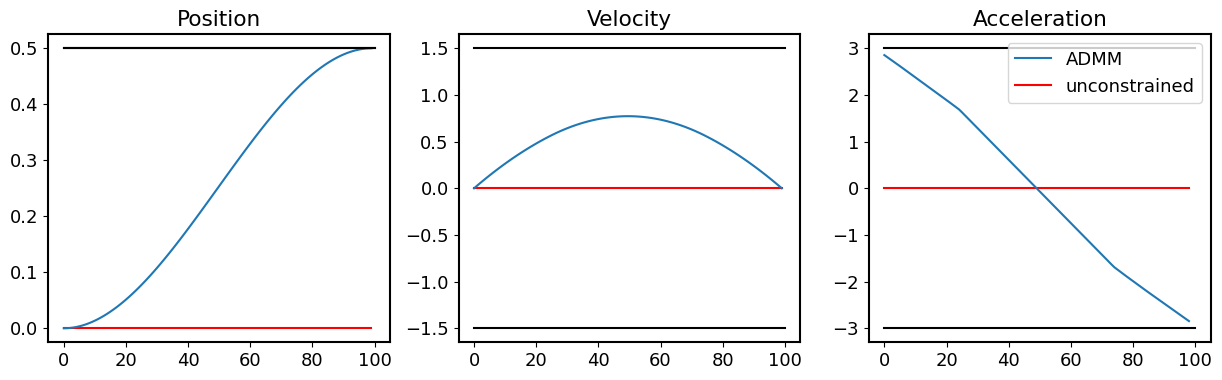

In [10]:
%%time

x_optimal, u_optimal,  K_optimal, k_optimal ,log_DP = sls.ADMM_LQT_DP(np.zeros(d), project_x=project_x,project_u=project_u ,
                                                          max_iter=5000,  rho_x=rho_x, rho_u=rho_u, threshold=1e-4, verbose=False, log=True)
fig,ax = plt.subplots(ncols=3, figsize=(15,4))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "k")
ax[0].plot([0,N],[upper_x_final]*2, "k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(x_opt[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "k")
ax[1].plot([0,N],[upper_dx]*2, "k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
print("Constrained cost is", "{:.2e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.compute_cost(x_opt, u_opt)))

## Robust solution

In [33]:
from scipy.stats import norm

# For robust constraints only for x0's position, z has dim 1+x_dim
x0_pos = np.zeros(x_dim)
mu = np.zeros(x_dim + 1) # [1, x0]
mu[0] = 1. 
mu[1:] = x0_pos

var_x0 = 0.02
sigma = np.zeros(x_dim + 1)
sigma[0] = 0. # first term is deterministic and equal to one.
sigma[1:] = var_x0 # variance for the x0
psi_inv = norm.ppf(0.9)
# psi_inv = norm.ppf(0.5)+1e-100 # should be the same as expected
 
Au = np.diag(np.sqrt(sigma))
bu = np.zeros(Au.shape[0])
cu = -mu/psi_inv
du = upper_u/psi_inv

Al = Au
bl = bu
cl = mu/psi_inv
dl = -lower_u/psi_inv

As = [Au, Al]
bs = [bu, bl]
cs = [cu, cl]
ds = [du, dl]

nb_proj_u = 2 # nb of projections needed for each row of psi_u
max_iter_set = 100
A_ = [np.concatenate([As[i] ,cs[i][None]], axis=0) for i in range(nb_proj_u)]
b_ = [np.append(bs[i], ds[i]) for i in range(nb_proj_u)]
threshold = 1e-2
project_u = lambda y: project_set_convex(y, A_, b_, projections=[project_soc_unit]*nb_proj_u, max_iter=max_iter_set,threshold=threshold,  verbose=False)
    
# #####################################################################

# For robust constraints only for x0's position, z has dim 1+x_dim
ds_x_final = [upper_x_final/psi_inv, -lower_x_final/psi_inv]
ds_dx = [upper_dx/psi_inv, -lower_dx/psi_inv]
ds_dx_final = [0., 0]

b_x_final = [np.append(bs[i], ds_x_final[i]) for i in range(nb_proj_u)]
b_dx_final = [np.append(bs[i], ds_dx_final[i]) for i in range(nb_proj_u)]

def project_x(x):
    x_ = x.copy()
    x_[-2:-1] = project_set_convex(x_[-2:-1], A_, b_x_final , projections=[project_soc_unit]*2, max_iter=max_iter_set, threshold=threshold)
    x_[-1:]   = project_set_convex(x_[-1:]  , A_, b_dx_final, projections=[project_soc_unit]*2, max_iter=max_iter_set, threshold=threshold)
    return x_


Start iterating..
ADMM residuals-> primal: 3.88e-06 dual: 9.69e-05
ADMM: Max iteration reached.
Constrained cost is 3.46e-02
Unconstrained cost is 0.00e+00
Wall time: 4.34 s


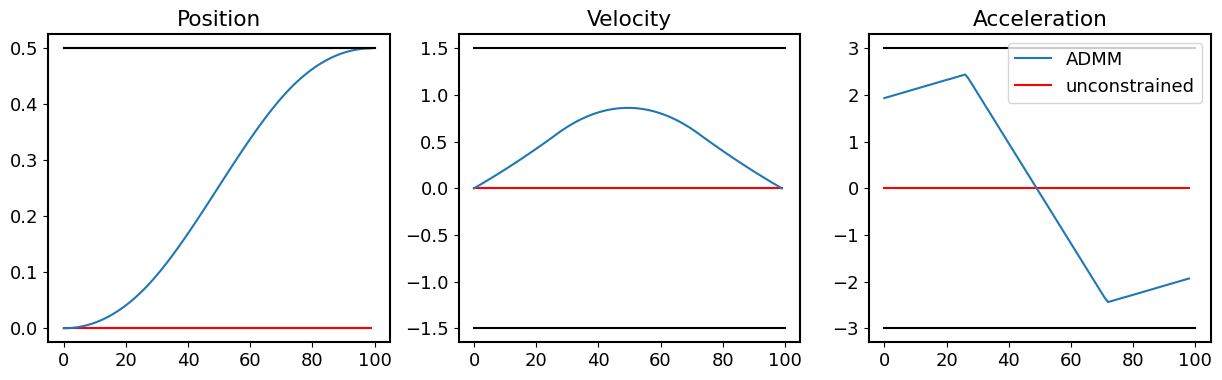

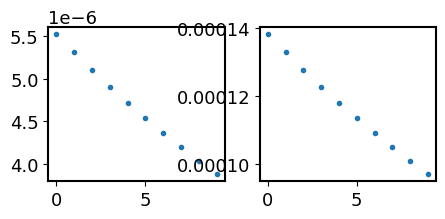

In [34]:
%%time
# Final timestep position and all timestep velocities are constrained.
rho_x = np.zeros((N, d, d))
rho_x[-1, 0, 0] = 1e3 # Final timestep position
rho_x[-1, 1, 1] = 1e3 # Final timestep velocity
rho_u = 1e-3
alpha = 1.
x0 = np.zeros(d)
max_iter = 200
du, PHI_U,log = sls.ADMM_SLS(project_u=project_u, project_x=project_x,
                         max_iter=max_iter, rho_x=rho_x, rho_u=rho_u,  alpha=alpha, threshold=1e-5, verbose=1, log=True)
u_optimal = du.copy()
fig,ax = plt.subplots(ncols=3, figsize=(15,4))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(x_opt[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "k")
ax[0].plot([0,N],[upper_x_final]*2, "k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(x_opt[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "k")
ax[1].plot([0,N],[upper_dx]*2, "k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(u_opt[:-1], "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
print("Constrained cost is", "{:.2e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.compute_cost(x_opt, u_opt)))
fig,ax= plt.subplots(ncols=2, figsize=(5,2))
ax[0].plot(np.stack(log)[-10:,0], ".")
ax[1].plot(np.stack(log)[-10:,1], ".")

### Experiment 1: Try 10000 different initial states and compare the statistics of success with the one that is provided to the robust optimal controller

In [35]:
noise_scale = 0.0
scale_x0 = np.sqrt(var_x0)
nb_experiments = 10000

x_logs = np.zeros((2, nb_experiments, N,  x_dim*nb_deriv))
u_logs = np.zeros((2, nb_experiments, N,  u_dim))

x0s = np.zeros((nb_experiments, d))
x0s[:, :x_dim] = np.random.normal(loc=np.zeros(x_dim), scale=scale_x0, size=(nb_experiments, x_dim))

x_logs[0], u_logs[0] = sls.get_trajectory_dp(x0s, K_optimal, k_optimal, noise_scale=noise_scale)

K_sls, k_sls = sls.controller(PHI_U, du)
x_logs[1], u_logs[1] = sls.get_trajectory_sls(x0s, K_sls, k_sls, noise_scale=noise_scale)

In [36]:
thr = 1e-3
names = ["DP", "SLS"]
for i in range(2):
    sx = lower_x_final - thr <= x_logs[i,:,-1,0]
    sx = sx * (x_logs[i,:,-1,0] <= upper_x_final + thr)
    su = np.all(lower_u - thr <= u_logs[i,:,:,:], axis=(1,2))
    su = su * np.all(u_logs[i,:,:,:] <= upper_u + thr, axis=(1,2))
    sdx = np.abs(x_logs[i,:,-1,1]) <= thr
    print("Percentage of success for", names[i], 100*np.sum(su*sx*sdx)/nb_experiments)
# print("Percentage of success for", names[i], 100*np.sum(su)/nb_experiments)

Percentage of success for DP 4.82
Percentage of success for SLS 89.16


### Experiment 2: Compare DP solution (non-robust) and SLS solution (robust)

In [37]:
noise_scale = 0.0
scale_x0 = np.sqrt(var_x0)
nb_experiments = 5

x_logs = np.zeros((2, nb_experiments, N,  x_dim*nb_deriv))
u_logs = np.zeros((2, nb_experiments, N,  u_dim))

x0s = np.zeros((nb_experiments, d))
x0s[:, :x_dim] = np.random.normal(loc=np.zeros(x_dim), scale=scale_x0, size=(nb_experiments, x_dim))

x_logs[0], u_logs[0] = sls.get_trajectory_dp(x0s, K_optimal, k_optimal, noise_scale=noise_scale)

K_sls, k_sls = sls.controller(PHI_U, du)
x_logs[1], u_logs[1] = sls.get_trajectory_sls(x0s, K_sls, k_sls, noise_scale=noise_scale)
thr = 1e-2
names = ["DP", "SLS"]
for i in range(2):
    sx = lower_x_final - thr <= x_logs[i,:,-1,0]
    sx = sx * (x_logs[i,:,-1,0] <= upper_x_final + thr)
    su = np.all(lower_u - thr <= u_logs[i,:,:,:], axis=(1,2))
    su = su * np.all(u_logs[i,:,:,:] <= upper_u + thr, axis=(1,2))
    sdx = np.all(np.abs(x_logs[i,:,-1,1]) <= thr, axis=-1)
    print("Percentage of success for", names[i], 100*np.sum(su*sx*sdx)/nb_experiments)

Percentage of success for DP 0.0
Percentage of success for SLS 100.0


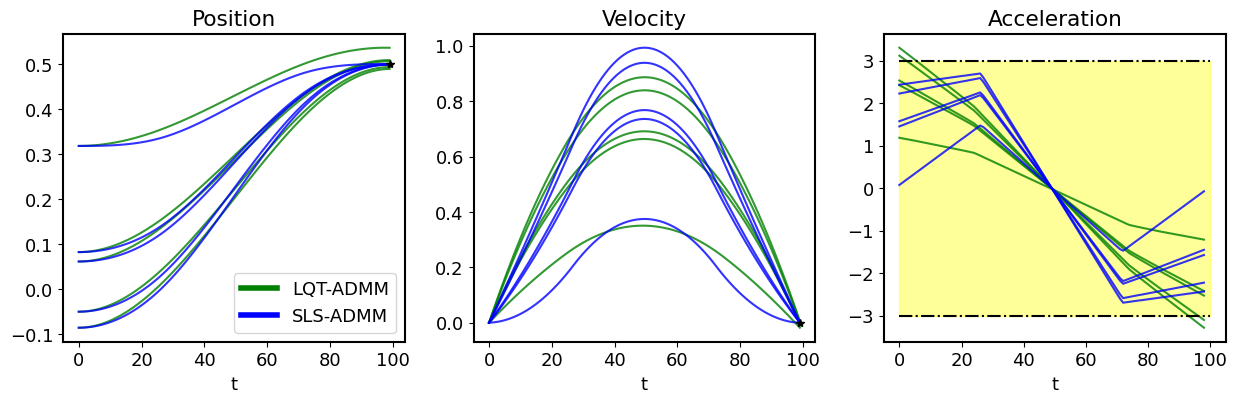

In [38]:
colors = ["g", "b", "orange"]
fig,axes = plt.subplots(nrows=x_dim, ncols=3, figsize=(15,4))

# vias = [via1, via2, via1_, via2_]
# times = [via_time1, via_time2, via_time1_, via_time2_ ]
titles = ["Position", "Velocity", "Acceleration"]
ylabels = np.array([[r"$x$",r"$\dot{x}$",r"$\ddot{x}$"],[r"$y$",r"$\dot{y}$",r"$\ddot{y}$"]])
label =[r"$V_1$", r"$V_2$",r"$VN_1$",r"$VN_2$",]
markers = ["_", "_", "_", "_"]
colors_markers = ["r", "r", "magenta", "magenta"]

changed = True
for i in range(2):
    axes[0].plot(x_logs[i,:,:,0].T, color=colors[i], alpha=0.8)
    axes[1].plot(x_logs[i,:,:,1].T, color=colors[i], alpha=0.8)
    axes[2].plot(u_logs[i,:,:-1,0].T, color=colors[i], alpha=0.8)  
for i in range(3):
    axes[i].set_xlabel("t")
    axes[i].set_title(titles[i])
# axes[0].set_ylim([-1,1])

axes[0].plot(N-1, lower_x_final, "k*")
axes[1].plot(N-1, 0, "k*")

# axes[0].plot([0,N],[lower_x_final]*2, "k")
# axes[0].plot([0,N],[upper_x_final]*2, "k")
# axes[1].plot([0,N],[lower_dx]*2, "k")
# axes[1].plot([0,N],[upper_dx]*2, "k")
axes[2].plot([0,N],[lower_u]*2, "-.k")
axes[2].plot([0,N],[upper_u]*2, "-.k")

# axes[0].fill_between([0,100], lower_x_final, upper_x_final, alpha=0.4, color="yellow", label="constraint")
axes[2].fill_between([0,100], lower_u, upper_u, alpha=0.4, color="yellow", label="constraint")


# from matplotlib.lines import Line2D
from matplotlib.lines import Line2D  
custom_lines = [Line2D([0], [0], color=colors[i], lw=4) for i in range(len(colors))]

axes[0].legend(custom_lines, ['LQT-ADMM', 'SLS-ADMM'])